In [1]:
import xarray as xr
import numpy as np
import os.path as op
import dask.array as da
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from scipy.interpolate import interp1d
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs'

In [5]:
ys, dy = (116,15)
dt = 36e2
ts = int((ys*360*86400)/12e2 + 14*360*86400/dt)
te = int(ts + (dy-14)*360*86400/dt)
print(ts,te)

3127680 3136320


In [6]:
ds1 = open_mdsdataset(op.join(ddir,'Layers_20km'), 
#                       grid_dir=op.join(ddir,'20km_grid'),
                     iters=range(ts+24,te+24,24),
                     prefix=['LAYERS-transport'],
                     delta_t=dt
                     )
ds1

<xarray.Dataset>
Dimensions:              (XC: 50, XG: 50, YC: 100, YG: 100, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 360)
Coordinates:
  * XC                   (XC) >f4 10000.0 30000.0 50000.0 ... 970000.0 990000.0
  * YC                   (YC) >f4 10000.0 30000.0 ... 1970000.0 1990000.0
  * XG                   (XG) >f4 0.0 20000.0 40000.0 ... 960000.0 980000.0
  * YG                   (YG) >f4 0.0 20000.0 40000.0 ... 1960000.0 1980000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -2727.5 -2830.5 -2933.5
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -2779.0 -2882.0 -2985.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 ... -2676.0 -2779.0 -2882.0
    rA                   (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dxG                  (YG, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
 

In [7]:
print(ds1.layer_1TH_bounds, ds1.layer_1TH_center, ds1.layer_1TH_interface)

<xarray.DataArray 'layer_1TH_bounds' (layer_1TH_bounds: 43)>
array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,
        7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2], dtype=float32)
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 ... 7.8 8.0 8.2
Attributes:
    standard_name:      ocean_layer_coordinate_1TH_bounds
    long_name:          boundaries points of layer 1TH
    axis:               1TH
    c_grid_axis_shift:  -0.5 <xarray.DataArray 'layer_1TH_center' (layer_1TH_center: 42)>
array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,  4.5,
        4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,  6.7,  6.9,
        7.1,  7.3,  7.5,  7.7,  7.9,  8.1], dtype=float32)
Coordin

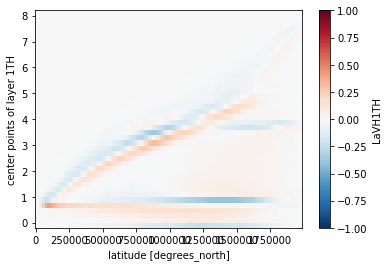

In [72]:
ds1.LaVH1TH[:].mean(['time','XC']).plot(vmax=1e0)

In [5]:
grid = Grid(ds1, periodic=['X'])
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z (40) --> left
  * left     Zl (40) --> center
  * outer    Zp1 (41) --> center
  * right    Zu (40) --> center
T Axis (not periodic):
  * center   time (5400)
X Axis (periodic):
  * center   XC (50) --> left
  * left     XG (50) --> center
Y Axis (not periodic):
  * center   YC (100) --> left
  * left     YG (100) --> center
1TH Axis (not periodic):
  * center   layer_1TH_center (42) --> outer
  * outer    layer_1TH_bounds (43) --> center
  * inner    layer_1TH_interface (41) --> center

In [6]:
# layer_1TH_bounds = np.array([-0.2,0.0,0.2,0.4,0.6,0.8,1.0,
#                             1.2,1.4,1.6,1.8,2.0,
#                             2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,
#                             4.2,4.4,4.6,4.8,5.0,5.2,5.4,5.6,5.8,6.0,
#                             6.2,6.4,6.6,6.8,7.0,7.2,7.4,7.6,7.8,8.0,8.2])
# layer_1TH_center = .5*(layer_1TH_bounds[1:]+layer_1TH_bounds[:-1])
with ProgressBar():
    psi_clim = -grid.cumsum((ds1.LaVH1TH.mean('time')*ds1.dxG).sum('XC'),
                           '1TH', boundary='fill'
                           ).rename('psi').compute()
#     psi_clim = -np.cumsum((ds1.LaVH1TH.mean('time')*ds1.dxG).sum('XC'),
#                          axis=0 
#                          ).compute()
psi_clim

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  5min 39.7s


<xarray.DataArray 'psi' (layer_1TH_bounds: 43, YG: 100)>
array([[-0.000000e+00, -0.000000e+00, -0.000000e+00, ..., -0.000000e+00,
        -0.000000e+00, -0.000000e+00],
       [-0.000000e+00, -0.000000e+00, -3.902114e+03, ...,  1.233910e+04,
         1.201372e+04, -6.893364e+03],
       [-0.000000e+00, -0.000000e+00, -2.610284e+03, ...,  1.874001e+04,
         1.696721e+04, -6.556462e+03],
       ...,
       [-0.000000e+00, -0.000000e+00,  1.350159e+00, ..., -4.006250e+02,
        -2.932664e+03, -3.702893e+03],
       [-0.000000e+00, -0.000000e+00,  1.350159e+00, ...,  1.912384e+00,
         1.282715e+00,  6.445312e-01],
       [-0.000000e+00, -0.000000e+00,  1.350159e+00, ...,  1.912384e+00,
         1.282715e+00,  6.445312e-01]], dtype=float32)
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0 ...
  * YG                (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 ...

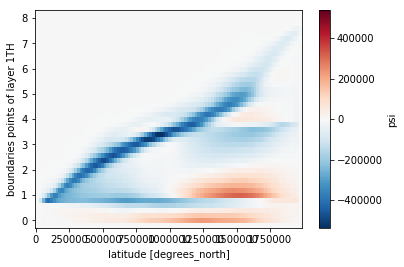

In [85]:
psi_clim.plot()

In [55]:
# func = interp1d(layer_1TH_center, psi_clim.data, axis=0, fill_value='extrapolate')
# psi_clim = xr.DataArray(func(layer_1TH_bounds), dims=['layer_1TH_bounds','YG'],
#                        coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data}
#                        )
# psi_clim

<xarray.DataArray (layer_1TH_bounds: 43, YG: 100)>
array([[-0.000000e+00, -0.000000e+00, -4.548029e+03, ...,  9.138648e+03,
         9.536974e+03, -7.061815e+03],
       [ 0.000000e+00,  0.000000e+00, -3.256199e+03, ...,  1.553955e+04,
         1.449047e+04, -6.724913e+03],
       [ 0.000000e+00,  0.000000e+00, -2.961637e+03, ...,  1.947692e+04,
         1.831057e+04, -6.378770e+03],
       ...,
       [ 0.000000e+00,  0.000000e+00,  1.350159e+00, ..., -1.993563e+02,
        -1.465691e+03, -1.851124e+03],
       [ 0.000000e+00,  0.000000e+00,  1.350159e+00, ...,  1.912384e+00,
         1.282715e+00,  6.445312e-01],
       [ 0.000000e+00,  0.000000e+00,  1.350159e+00, ...,  1.912384e+00,
         1.282715e+00,  6.445312e-01]])
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) float64 -0.2 0.0 0.2 0.4 0.6 0.8 ...
  * YG                (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 ...

In [81]:
vname = 'LaHs1TH' 
mean_thkns = ds1[vname].mean(['time','XC'])
# mean_thkns = xr.DataArray(mean_thkns.data[::-1], dims=['layer_1TH_center','YG'],
#                          coords={'layer_1TH_center':layer_1TH_center[::-1],'YG':ds1.YG.data}
#                          )
# mean_cum = np.cumsum(mean_thkns, axis=0)
# func = interp1d(layer_1TH_center[::-1], mean_cum, axis=0, fill_value='extrapolate')
# mean_cum = func(layer_1TH_bounds[::-1])
# mean_cum

mean_thkns[::-1]

<xarray.DataArray 'LaHs1TH' (layer_1TH_center: 42, YG: 100)>
dask.array<shape=(42, 100), dtype=float32, chunksize=(42, 100)>
Coordinates:
  * YG                (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 ...
  * layer_1TH_center  (layer_1TH_center) float32 8.1 7.9 7.7 7.5 7.3 7.1 6.9 ...

[########################################] | 100% Completed | 15.1s


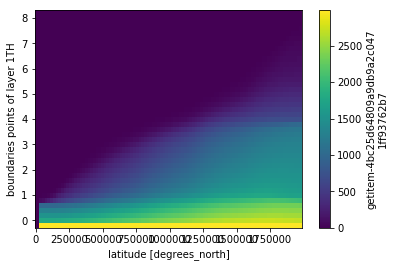

In [84]:
with ProgressBar():
#     zb = xr.DataArray(mean_cum[::-1],
#                      dims=['layer_1TH_bounds','YG'],
#                      coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data}
#                      ).compute()
      zb = xr.DataArray(grid.cumsum(mean_thkns[::-1], '1TH', boundary='fill')[::-1].data,
                       dims=['layer_1TH_bounds','YG'],
                       coords={'layer_1TH_bounds':ds1.layer_1TH_bounds,'YG':ds1.YG}
                       ).compute()
zb.plot()

In [7]:
def get_layer_depths(ds, dim, layers_name='1TH', point='s'):
    lprefix = 'layer_' + layers_name
    vname = 'LaH' + point + layers_name
    mn_thkns = ds[vname].mean(['time','XC'])
    
    # this represents the depth of the layers1TH_bounds points
    # (used as the boundaries of the center values)
    zb = xr.DataArray(grid.cumsum(mn_thkns[::-1], '1TH', boundary='fill')[::-1].data,
                     dims=['layer_1TH_bounds','YG'],
                     coords={'layer_1TH_bounds':ds.layer_1TH_bounds,'YG':ds.YG}
                     )
    
    # and this is the depth of the layers1TH_center points
    # (used as the boundaries of the interface values)
    zc = grid.interp(zb,'1TH',boundary='fill')
    
    # the interface depths
    zi = zb[1:-1].rename({lprefix+'_bounds': lprefix+'_interface'})
    
    z= {lprefix + '_bounds': zb,
        lprefix + '_center': zc,
        lprefix + '_interface': zi}
    return z[dim]

In [74]:
# def get_layer_depths(ds, dim, layers_name='1TH', point='s'):
#     lprefix = 'layer_' + layers_name
#     vname = 'LaH' + point + layers_name
#     mn_thkns = ds[vname].mean(['time','XC'])
# #     mn_thkns = xr.DataArray(mn_thkns.data[::-1], dims=['layer_1TH_center','YG'],
# #                            coords={'layer_1TH_center':layer_1TH_center[::-1],'YG':ds1.YG.data}
# #                            )
# #     mean_cum = np.cumsum(mn_thkns, axis=0)
# #     func = interp1d(layer_1TH_center[::-1], mean_cum, axis=0, fill_value='extrapolate')
# #     mean_cum = func(layer_1TH_bounds[::-1])
    
#     # this represents the depth of the layers1TH_bounds points
#     # (used as the boundaries of the center values)
#     zb = xr.DataArray(grid.cumsum(mean_thkns[::-1], '1TH', boundary='fill')[::-1].data,
#                      dims=['layer_1TH_bounds','YG'],
#                      coords={'layer_1TH_bounds':ds.layer_1TH_bounds,'YG':ds.YG}
#                      )
# #     zb = xr.DataArray(mean_cum[::-1],
# #                      dims=['layer_1TH_bounds','YG'],
# #                      coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data}
# #                      )
    
#     # and this is the depth of the layers1TH_center points
#     # (used as the boundaries of the interface values)
#     zc = grid.interp(zb,'1TH',boundary='fill')
# #     zc = xr.DataArray(.5*(zb[1:].data+zb[:-1].data), dims=['layer_1TH_center','YG'], 
# #                       coords={'layer_1TH_center':layer_1TH_center,'YG':ds1.YG.data})
    
#     # the interface depths
#     zi = zb[1:-1].rename({lprefix+'_bounds': lprefix+'_interface'})
    
#     z= {lprefix + '_bounds': zb,
#         lprefix + '_center': zc,
#         lprefix + '_interface': zi}
#     return z[dim]

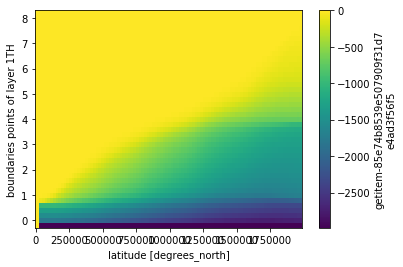

In [8]:
z = -get_layer_depths(ds1, psi_clim.dims[0], layers_name='1TH')
y = np.tile(ds1.YC.values[np.newaxis,:], (z.shape[0],1))
z.plot()

In [12]:
# xr.DataArray(psi_clim, dims=['layer_1TH_bounds','YG'], 
#              coords={'layer_1TH_bounds':layer_1TH_bounds,'YG':ds1.YG.data,
#                     'z':(('layer_1TH_bounds','YG'),z),'y':(('layer_1TH_bounds','YG'),y)}
#             ).to_dataset(name='psi_res').to_netcdf(op.join(ddir,'Climatological-psi_20km.nc'))
psi_clim.coords['z'] = (('layer_1TH_bounds','YG'),z)
psi_clim.coords['y'] = (('layer_1TH_bounds','YG'),y)
save = psi_clim.to_dataset(name='psi_res')
# save.coords['z'] = (('layer_1TH_bounds','YG'),z)
# save.coords['y'] = (('layer_1TH_bounds','YG'),y)
save.to_netcdf(op.join(ddir,'Climatological-psi_20km.nc'))
save

<xarray.Dataset>
Dimensions:           (YG: 100, layer_1TH_bounds: 43)
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0 ...
  * YG                (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 ...
    z                 (layer_1TH_bounds, YG) float32 -0.0 -0.0 -2985.0 ...
    y                 (layer_1TH_bounds, YG) >f4 10000.0 30000.0 50000.0 ...
Data variables:
    psi_res           (layer_1TH_bounds, YG) float32 -0.0 -0.0 -0.0 -0.0 ...

In [46]:
ys, dy = (58,20)
dtT = 12e2
tsT = int((ys*360*86400)/8e2 + 9*360*86400/dtT)
teT = int(tsT + (dy*360*86400)/dtT)
print(tsT,teT)
dsT = open_mdsdataset(op.join(ddir,'Phys-only_20km'), grid_dir=op.join(ddir,'20km_grid'),
                     iters=range(tsT+72,teT+72,72), prefix=['MOMtave'], delta_t=dtT
                     )
Ttave = dsT.THETA
with ProgressBar():
    T_clim = Ttave.mean(['time','XC']).load()
T_clim

2488320 3006720


/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/Phys-only_20km. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


[########################################] | 100% Completed | 16.8s


<xarray.DataArray 'THETA' (Z: 40, YC: 100)>
array([[ 0.      ,  0.733716,  0.765656, ...,  7.581973,  7.696105,  7.822703],
       [ 0.      ,  0.734068,  0.765922, ...,  7.361503,  7.389323,  7.407722],
       [ 0.      ,  0.734144,  0.765942, ...,  7.238717,  7.225229,  7.207886],
       ...,
       [ 0.      , -0.217581, -0.216265, ...,  0.027336,  0.022037,  0.014344],
       [ 0.      , -0.222947, -0.221364, ..., -0.091687, -0.096034, -0.101658],
       [ 0.      , -0.225537, -0.223731, ..., -0.134882, -0.136646, -0.138135]],
      dtype=float32)
Coordinates:
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 16.0 19.0 22.0 26.0 30.0 36.0 ...
    PHrefC   (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 799.515 ...

In [62]:
alpha = 2e-4
g = 9.81
N2 = alpha*g * (grid.diff(T_clim, 'Z', boundary='fill', to='outer')
                / grid.diff(T_clim.Z, 'Z', boundary='fill', to='outer')
               )
N2

<xarray.DataArray (Zp1: 41, YC: 100)>
array([[-0.000000e+00, -2.879103e-04, -3.004433e-04, ..., -2.975166e-03,
        -3.019952e-03, -3.069629e-03],
       [-0.000000e+00, -6.891528e-08, -5.226241e-08, ...,  4.325630e-05,
         6.019077e-05,  8.141934e-05],
       [-0.000000e+00, -1.491040e-08, -3.882551e-09, ...,  2.409062e-05,
         3.219514e-05,  3.920769e-05],
       ...,
       [-0.000000e+00,  1.022073e-07,  9.712112e-08, ...,  2.267213e-06,
         2.249065e-06,  2.209669e-06],
       [-0.000000e+00,  4.933318e-08,  4.509112e-08, ...,  8.228045e-07,
         7.736018e-07,  6.948273e-07],
       [ 0.000000e+00,  1.508446e-07,  1.496371e-07, ...,  9.021247e-08,
         9.139216e-08,  9.238817e-08]], dtype=float32)
Coordinates:
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...

In [49]:
MLD = xr.open_dataset(op.join(ddir,'KPPMLD_20km.nc')).mld.mean('time')
XLD = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_20km.nc')).hbl99.mean('time')
MLD

<xarray.DataArray 'mld' (YC: 100, XC: 50)>
array([[   0.      ,    0.      ,    0.      , ...,    0.      ,    0.      ,
           0.      ],
       [1899.5054  , 1896.6514  , 1888.2952  , ..., 1902.5223  , 1902.8528  ,
        1899.7244  ],
       [1836.9565  , 1837.51    , 1827.8893  , ..., 1850.3972  , 1846.0536  ,
        1838.0748  ],
       ...,
       [  55.95569 ,   55.983994,   55.98749 , ...,   55.729404,   55.875538,
          55.98421 ],
       [  47.44934 ,   47.4715  ,   47.556915, ...,   47.619114,   47.70191 ,
          47.65877 ],
       [  38.242683,   38.238174,   38.28984 , ...,   38.407978,   38.510815,
          38.4266  ]], dtype=float32)
Coordinates:
  * XC       (XC) float32 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) float32 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
    rA       (YC, XC) float32 ...
    Depth    (YC, XC) float32 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


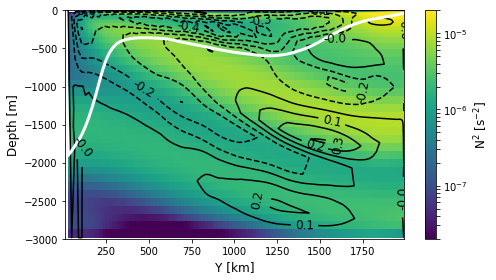

In [95]:
psilevs = np.arange(-.8,.9,0.1) + 0.

fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
# ax1.plot(Q.YC*1e-3, Q.mean(['time','XC']), 'k', lw=2)
# ax1.set_xlim([0,1995.])
# ax1.set_ylabel(r"Q [w m$^{-2}$]", fontsize=12)
im = ax.pcolormesh(N2.YC*1e-3, N2.Zp1, N2,
                  norm=clrs.LogNorm(), vmin=2e-8, vmax=2e-5, rasterized=True)
ct = ax.contour(y*1e-3, z, psi_clim.data*1e-6,
               colors='k', levels=psilevs, extend='both')
ax.plot(MLD.YC*1e-3, -MLD.mean('XC'), color='white', lw=3)
ax.set_xlabel(r'Y [km]', fontsize=12)
ax.set_ylabel(r'Depth [m]', fontsize=12)
ax.set_ylim([-3e3,0])
plt.clabel(ct, inline=1, fmt='%1.1f', fontsize=12)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'N$^2$ [s$^{-2}$]', fontsize=12)
plt.savefig(op.join(ddir,'Figures/Overturning-psi_20km.pdf'))